# **Upload and Load Dataset**

In [1]:
!pip install yfinance --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import math
from google.colab import files

In [5]:
uploaded = files.upload()

Saving HistoricalQuotes.csv to HistoricalQuotes.csv


In [6]:
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [13]:
# Re-read the CSV, treating the first column as the date index
df = pd.read_csv('HistoricalQuotes.csv', index_col=0)

df.columns = df.columns.str.strip().str.replace('\ufeff', '')
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

df.index = pd.to_datetime(df.index)

df.head()


,Close,Volume,Open,High,Low
Date,,,,,
2020-02-28,$273.36,106721200,$257.26,$278.41,$256.37
2020-02-27,$273.52,80151380,$281.1,$286,$272.96
2020-02-26,$292.65,49678430,$286.53,$297.88,$286.5
2020-02-25,$288.08,57668360,$300.95,$302.53,$286.13
2020-02-24,$298.18,55548830,$297.26,$304.18,$289.23


In [16]:
# Remove $ and commas, strip whitespace, and convert to float
for col in ['Close', 'Open', 'High', 'Low', 'Volume']:
    df[col] = df[col].astype(str).str.replace('$', '', regex=False)
    df[col] = df[col].str.replace(',', '', regex=False)
    df[col] = df[col].str.strip()
    df[col] = df[col].astype(float)


In [17]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
df.rename(columns={'Close/Last': 'Close'}, inplace=True)
df.index = pd.to_datetime(df.index)


# **Visualize Closing Price**

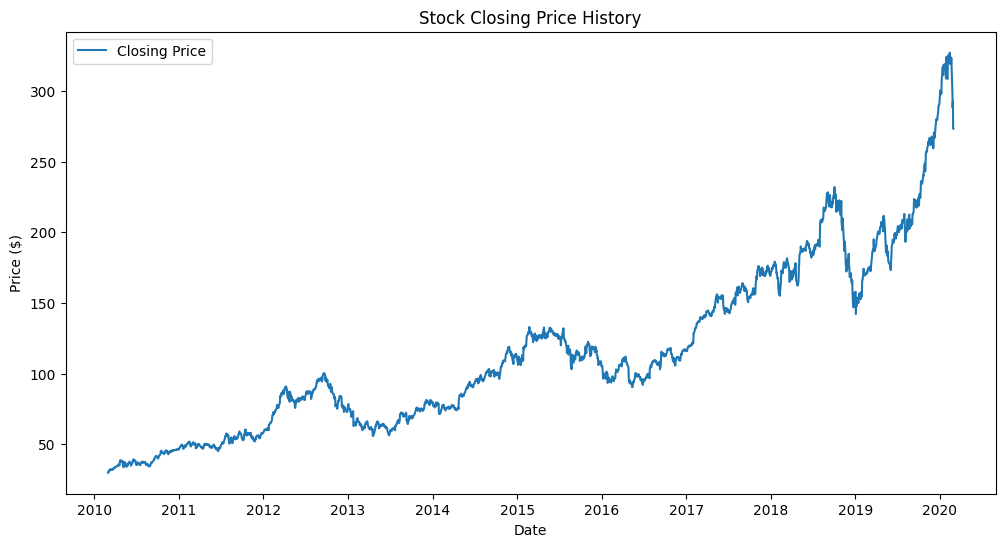

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Closing Price')
plt.title('Stock Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


# **Data Preprocessing for LSTM**

In [19]:
# Use only 'Close' prices
data = df[['Close']].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Train/test split (80%)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

# Create sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# **Build and Train the LSTM Modelt**

In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop])


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0398 - val_loss: 0.0029
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0014 - val_loss: 1.6170e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 3.2470e-04 - val_loss: 1.4787e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.2066e-04 - val_loss: 1.4555e-04
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.0367e-04 - val_loss: 1.4503e-04
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.0644e-04 - val_loss: 1.4403e-04
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 3.1345e-04 - val_loss: 1.4216e-04
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 2.7992e-04 - val_loss: 1.4111e-04
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 2.6467e-04 - val_loss: 1.3963e-04
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2.7438e-04 - val_loss: 1.3702e-04
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 2.4657e-04 - val_loss: 1.3718e

# **Predict and Evaluate**

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
RMSE: 1.91
MAE: 1.56


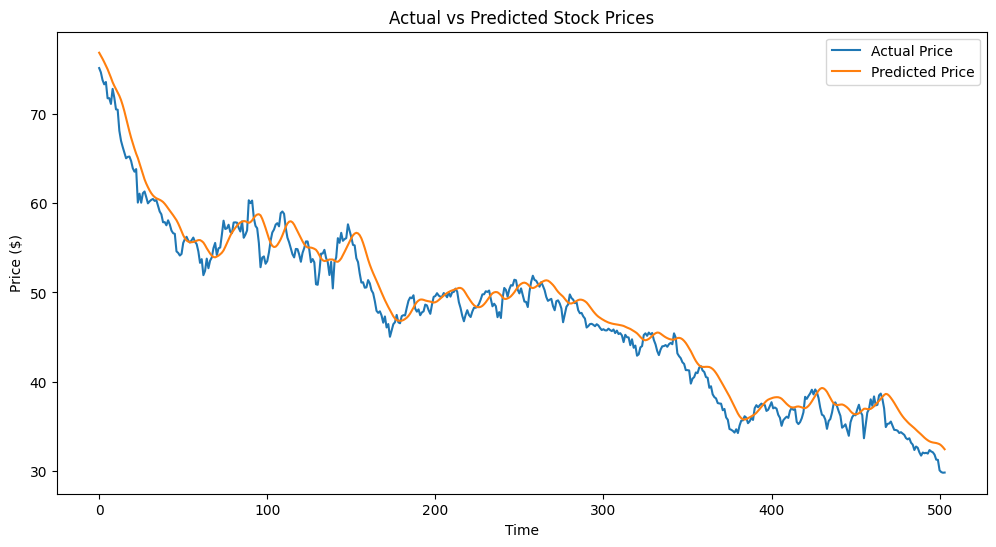

In [21]:
# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
rmse = math.sqrt(mean_squared_error(y_true, predictions))
mae = mean_absolute_error(y_true, predictions)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


# *Predict Next n_days Ahead*

In [22]:
n_days = 7  # forecast horizon

last_60_days = scaled_data[-60:].reshape(1, 60, 1)

predicted_prices = []

for _ in range(n_days):
    # Predict the next day
    pred = model.predict(last_60_days)[0][0]
    predicted_prices.append(pred)

    # Update the input sequence
    last_60_days = np.append(last_60_days[:, 1:, :], [[[pred]]], axis=1)

# Inverse scale the predicted values
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Show predicted prices
for i, price in enumerate(predicted_prices, 1):
    print(f"Day {i}: ${price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Day 1: $32.22
Day 2: $32.10
Day 3: $32.07
Day 4: $32.11
Day 5: $32.20
Day 6: $32.33
Day 7: $32.49


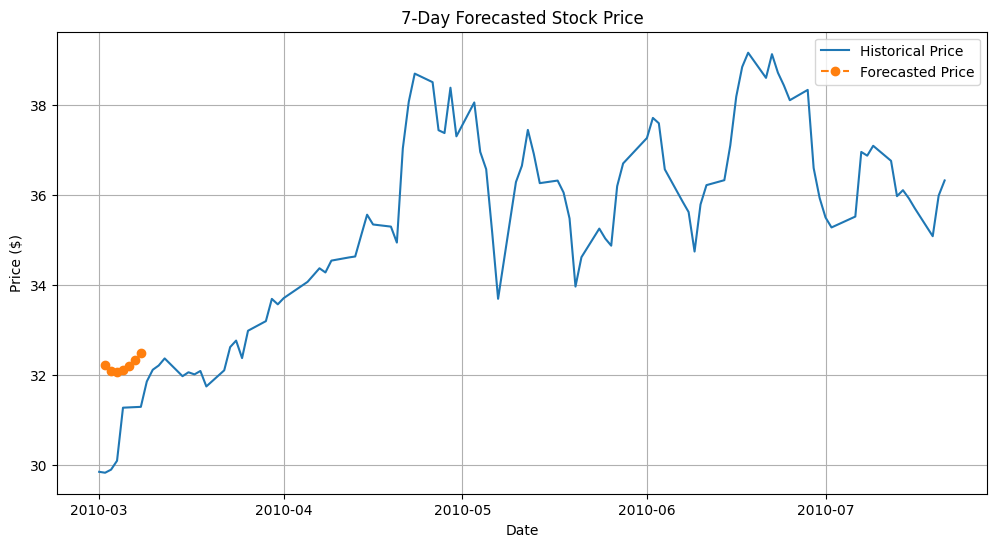

In [23]:
import matplotlib.pyplot as plt

# Extend time axis
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_days)

plt.figure(figsize=(12,6))
plt.plot(df.index[-100:], df['Close'].values[-100:], label='Historical Price')
plt.plot(future_dates, predicted_prices, label='Forecasted Price', linestyle='--', marker='o')
plt.title(f'{n_days}-Day Forecasted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


# *Data Preparation Improvements*

In [25]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()


*Normalize entire dataset*

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


# *Model Architecture Improvements*
 *Use more LSTM layers & neurons*

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=n_days))  # For multi-day forecast

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# *Train for more epochs + early stopping*

In [30]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0011 - val_loss: 1.0395e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0013 - val_loss: 1.7204e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 0.0011 - val_loss: 1.6677e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0011 - val_loss: 1.0645e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 9.1376e-04 - val_loss: 9.7014e-05
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 9.0509e-04 - val_loss: 9.2049e-05
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 9.8124e-04 - val_loss: 9.4051e-05
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 9.5507e-04 - val_loss: 1.7246e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 8.2860e-04 - val_loss: 9.8823e-05
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 9.0428e-04 - val_loss: 9.7510e-05
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 9.120

In [29]:
# For 60 days input and 7 days output
X, y = [], []
for i in range(60, len(scaled_data) - 7):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i:i+7, 0])  # 7-day future window


In [33]:
!pip install keras-tuner


In [34]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# *Define a model-building function with tunable hyperparameters*

In [35]:
def build_model(hp):
    model = Sequential()
    # Tune number of LSTM units between 50 and 200
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units2', min_value=50, max_value=200, step=50),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=1))  # For single value prediction

    # Tune learning rate for Adam optimizer
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    return model


# *Instantiate the tuner and search for best hyperparameters*

In [36]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,       # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='stock_lstm_tuning'
)


# *Run the tuner*

In [38]:
import tensorflow as tf


In [42]:
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=32,
             validation_split=0.2,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])


Trial 10 Complete [00h 01m 41s]
val_loss: 7.927994010969996e-05

Best val_loss So Far: 5.890099055250175e-05
Total elapsed time: 00h 23m 37s


# **Get the best hyperparameters and best model**

In [43]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best units in 1st LSTM layer: {best_hp.get('units')}
Best dropout rate 1: {best_hp.get('dropout_1')}
Best units in 2nd LSTM layer: {best_hp.get('units2')}
Best dropout rate 2: {best_hp.get('dropout_2')}
Best learning rate: {best_hp.get('learning_rate')}
""")

best_model = tuner.get_best_models(num_models=1)[0]



Best units in 1st LSTM layer: 200
Best dropout rate 1: 0.5
Best units in 2nd LSTM layer: 200
Best dropout rate 2: 0.1
Best learning rate: 0.006098158336710077



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
